In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout, add


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.01G/1.04G [00:05<00:00, 226MB/s]
100% 1.04G/1.04G [00:05<00:00, 198MB/s]


In [4]:
import zipfile
ref = zipfile.ZipFile('/content/flickr8k.zip', 'r')
ref.extractall('/content/flickr8k')
ref.close()

#Extract Image Features

In [5]:
#load vgg16
model = VGG16()
#restructure the model
model = Model(inputs= model.inputs, outputs = model.layers[-2].output)
# The layers attribute of a Keras model gives you access to all the layers in the mode
# In Keras, every model has an inputs attribute that gives you access to the input tensors of the model.
# For VGG16, this would be a tensor with shape (None, 224, 224, 3)
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define base directory
BASE_DIR = '/content/flickr8k'

# Define working directory and create it if it doesn't exist
WORKING_DIR = '/content/working'
os.makedirs(WORKING_DIR, exist_ok=True)  # This will create the directory if it doesn’t exist


In [7]:
# #Extract features from image
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')
# for img_name in tqdm(os.listdir(directory)):
#   img_path = directory +'/'+ img_name
#   image = load_img(img_path,target_size = (224, 224))
#   #convert image picture to numpy array
#   image = img_to_array(image)
#   #reshape data for model
#   image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
#   #preprocess image for vgg
#   image = preprocess_input(image)
#   #extract features
#   feature = model.predict(image,verbose = 0)
#   #since you've modified the model to output the -
#   #activations of a specific layer (e.g., the second-to-last layer), model.predict() will return the feature vector extracted by that layer.
#   #verbose is an optional argument in model.predict() that controls how much information is printed during the prediction process
#   #get image id
#   image_id = img_name.split('.')[0]
#   # store features
#   #feature = [[0.1, 0.5, -0.3, ..., 0.8]]  # Shape: (1, 4096)
#   features[image_id] = feature


In [8]:
# #store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
#load features from pickle
with open(os.path.join(WORKING_DIR, '/content/features.pkl'), 'rb') as f:
  features = pickle.load(f)

In [10]:
features

{'481732592_b50194cb89': array([[3.9117327, 1.7461429, 0.       , ..., 0.       , 5.698085 ,
         0.       ]], dtype=float32),
 '2380740486_8cd5d4601a': array([[2.5857048 , 2.0394416 , 0.        , ..., 0.        , 5.061861  ,
         0.39114928]], dtype=float32),
 '2723929323_70b93a74ea': array([[0.       , 2.019734 , 0.       , ..., 0.       , 2.6701305,
         1.5575987]], dtype=float32),
 '1481062342_d9e34366c4': array([[1.8968003 , 3.2881467 , 0.        , ..., 0.        , 0.27212402,
         1.0991083 ]], dtype=float32),
 '3434452829_62cee280bc': array([[0.       , 0.       , 0.       , ..., 0.       , 4.1867495,
         3.6271703]], dtype=float32),
 '3442844140_15aa45e9b8': array([[0.7693724, 0.       , 0.       , ..., 0.       , 0.       ,
         4.0629287]], dtype=float32),
 '3649307685_60c1294d2a': array([[0.        , 0.        , 0.88158035, ..., 0.        , 0.        ,
         4.539693  ]], dtype=float32),
 '816084977_21c1811c9a': array([[0.7101548 , 1.2014598 , 0.

#Load the caption data

In [11]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [12]:
#create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extension form image id
  image_id = image_id.split('.')[0]
  #convert caption list to string
  caption = ' '.join(caption)
  #create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  #store the caption
  mapping[image_id].append(caption)




  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(mapping)

8091

In [14]:
def clean(mappig):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      #take one caption at a time
      caption = captions[i]
      #preprocesing steps

      #convert to lower case
      caption = caption.lower()
      #delete digits special character etc.
      caption = caption.replace('[^A-Za-z]', '')
      #delete additional spaces
      caption = caption.replace('\s+', ' ')

      # this could be better choice to remove
      #import re
      # # Remove all non-alphabetic characters
      # caption = re.sub('[^A-Za-z]', '', caption)
      # # Replace multiple spaces with a single space
      # caption = re.sub('\s+', ' ', caption)

      #add start and end tags to the caption
      caption = 'start ' + " ".join([word for word in caption.split() if len(word)> 1]) + ' end'
      captions[i] = caption


In [15]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
clean(mapping)

In [17]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [18]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)


In [19]:
len(all_captions)

40455

In [20]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
#tokenizer index start with 1 and zero index reserved for
vocab_size = len(tokenizer.word_index)+1

In [21]:
vocab_size

8483

In [22]:
#get maximum lenght of the captions available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

#Train test split


In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)
train = image_ids[:split]
test = image_ids[split: ]

In [24]:
#start girl going into wooden building end
#         x     y
# input start , output : girl
#input start girl , output: going
#that means next word prediction approch will be follow

In [25]:
#create a data generator to get data in batch for efficiency of ram use
# to avoid session crush
def data_generator(data_keys, mapping, features, tokenizer, max_lenght, vocb_size, batch_size):
  x1,x2,y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      #process each caption
      for caption in captions:
        #encode the sequence
        #The reason you use [0] is because texts_to_sequences() always returns a list of lists , even if you pass only one caption
        seq = tokenizer.texts_to_sequences([caption])[0]
        #split the sequence into x,y pairs

        for i in range(1, len(seq)):
          #split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          #pad input sequence
          #pad_sequences() expects a list of sequences as input, where each sequence is itself a list of integers.
          in_seq = pad_sequences([in_seq], maxlen = max_length, padding = 'post')[0]
          #encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          #store the sequences
          #'481732592_b50194cb89': array([[3.9117327, 1.7461429, 0.       , ..., 0.       , 5.698085 ,0.       ]], dtype=float32)
          #That means for each key there are list if list shape(1,4046) that is why we will extract 0th index
          x1.append(features[key][0])
          x2.append(in_seq)
          y.append(out_seq)
      if n== batch_size:
        x1, x2, y = np.array(x1), np.array(x2), np.array(y)
        yield {'image':x1,'text':x2}, y
        x1, x2, y = list(), list(), list()
        n = 0






## Model Creation


In [26]:
output_sape_of_finetune_model = 4096


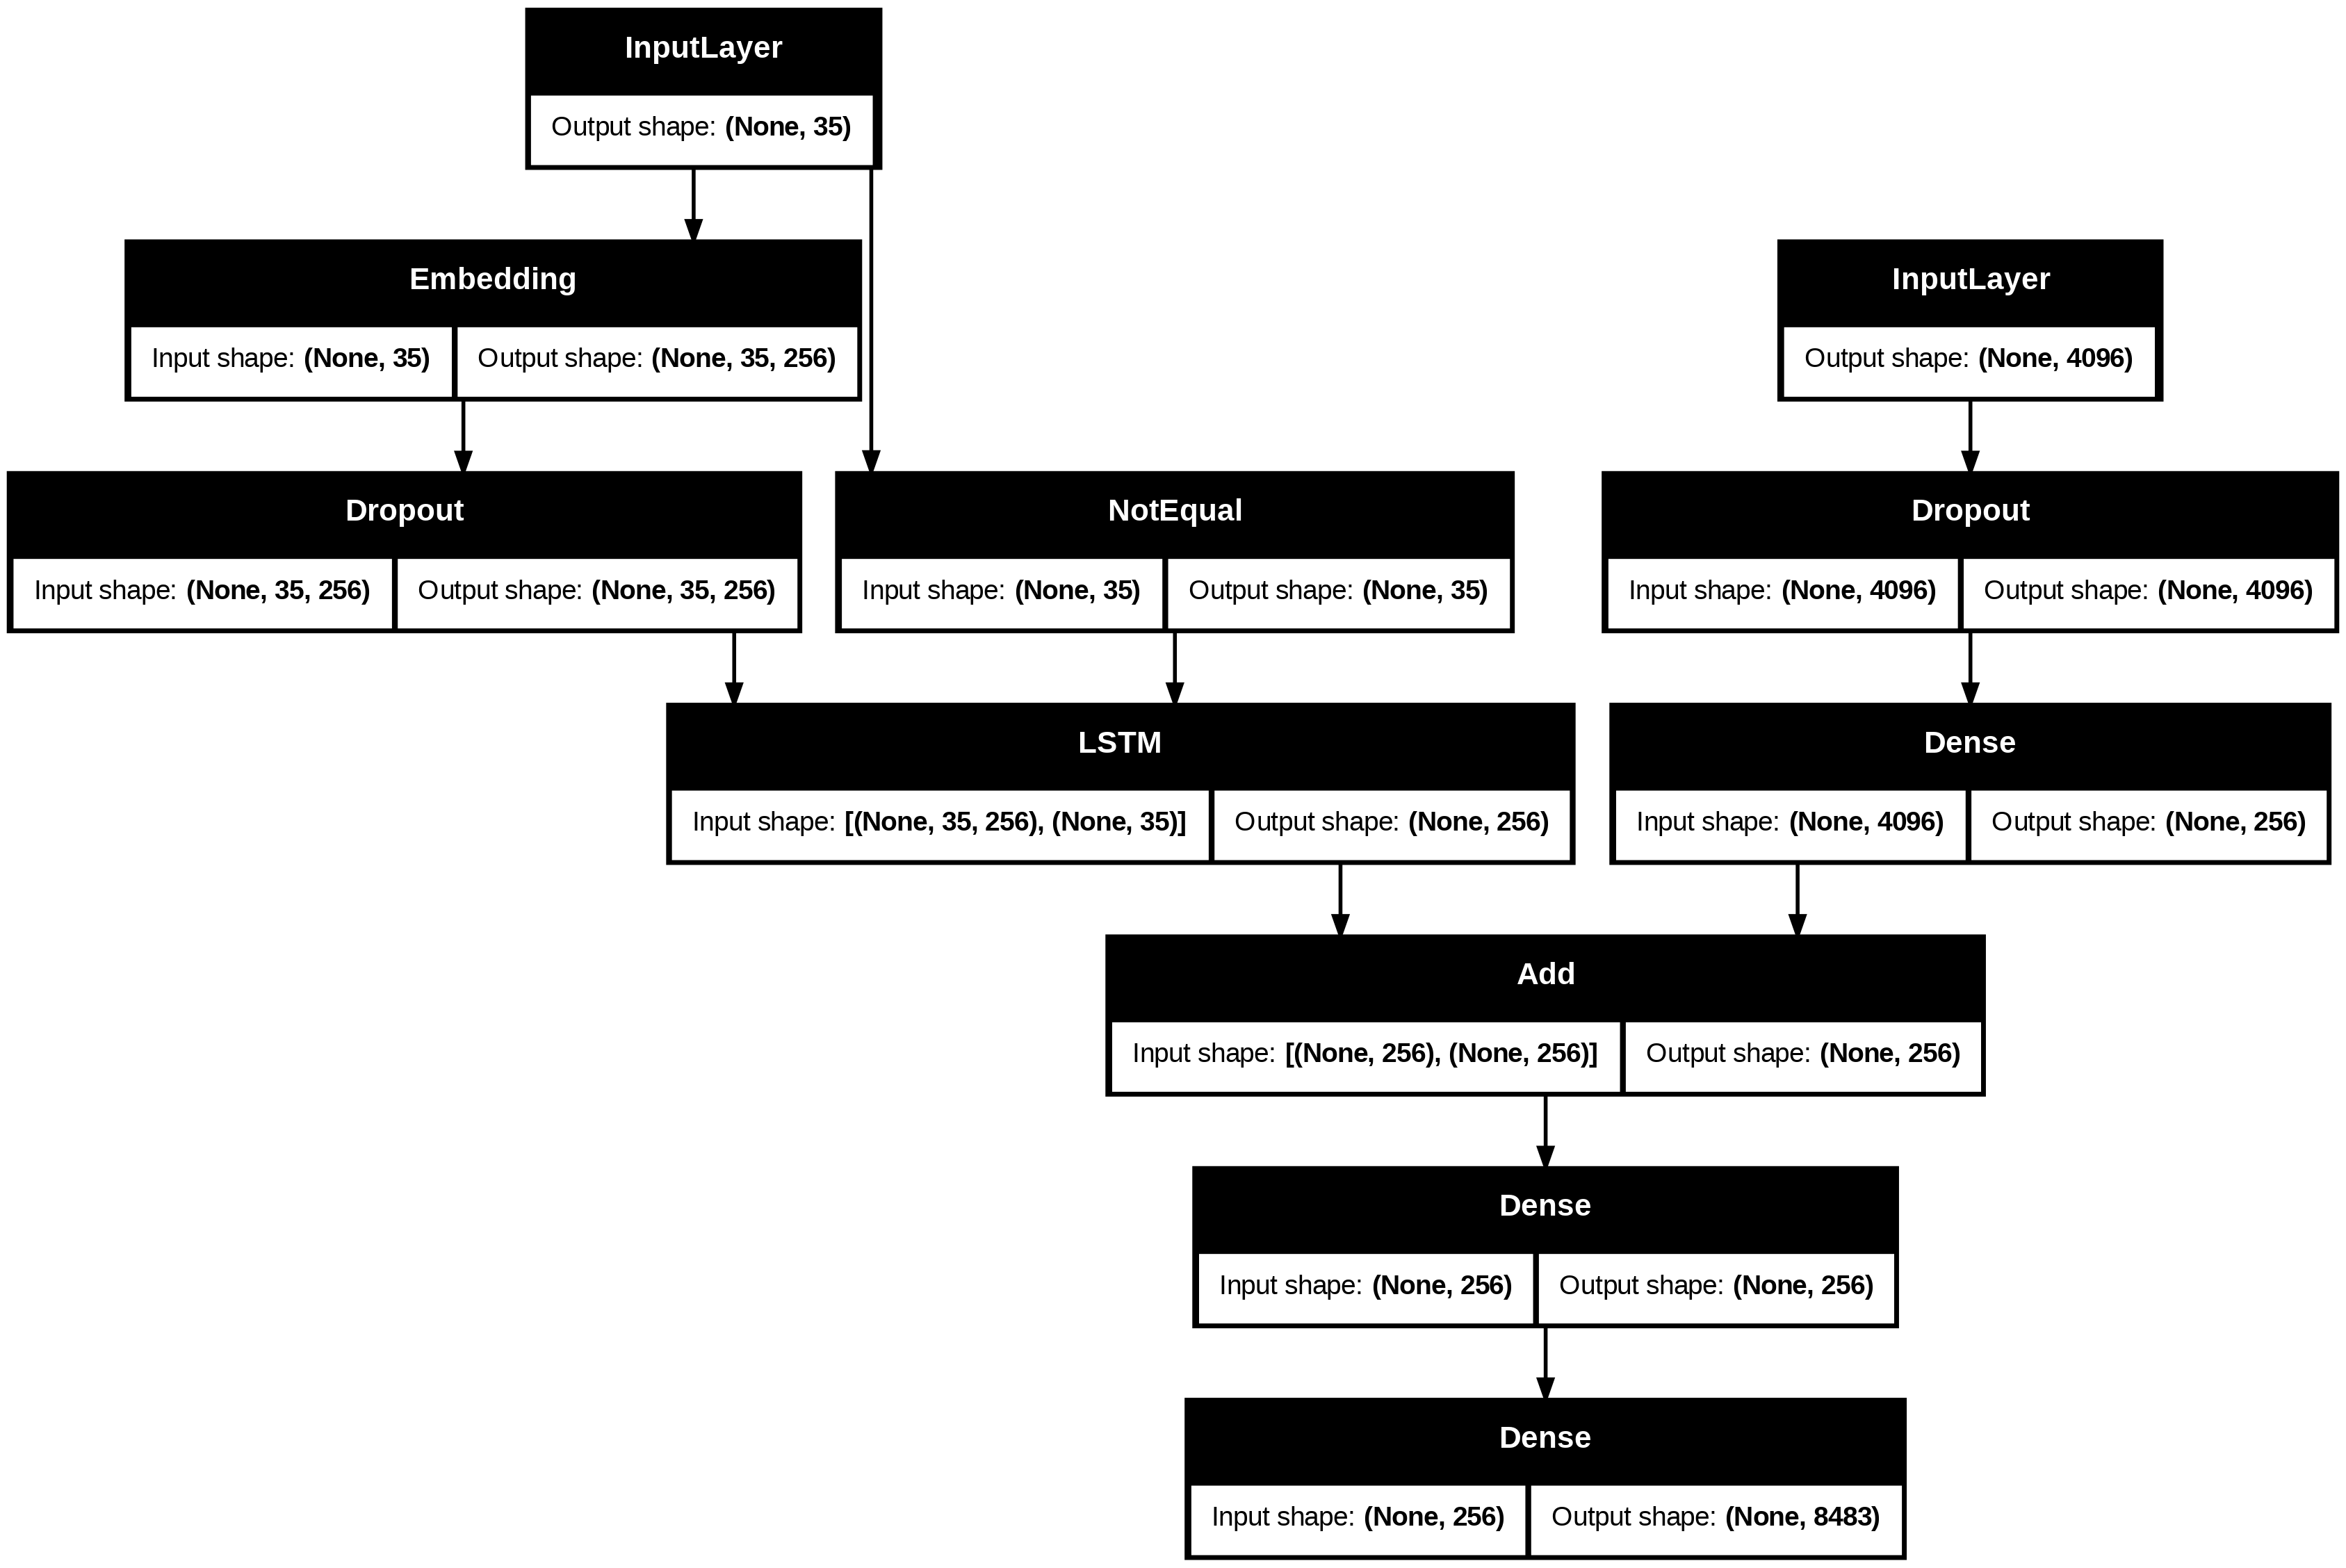

In [27]:
## Encoder Model
#image feature layers
inputs1 = Input(shape =(output_sape_of_finetune_model, ), name = 'image')
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
#sequence feature layers
inputs2 = Input(shape = (max_length, ), name = 'text')
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


## Decoder Model
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation= 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
#plot model
plot_model(model, show_shapes = True)

#Train the model

In [28]:
epochs = 30
batch_size = 16
steps = len(train)//batch_size

for i in range(epochs):
  #create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length,vocab_size, batch_size)
  #fit for one epoch
  model.fit(generator, epochs = 1, steps_per_epoch=steps, verbose = 1)

455/455 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - loss: 5.4860
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - loss: 3.9005
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - loss: 3.4733
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - loss: 3.2116
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 130ms/step - loss: 3.0157
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 129ms/step - loss: 2.8645
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - loss: 2.7510
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 130ms/step - loss: 2.6568
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - loss: 2.5824
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 130ms/step - loss: 2.5113
455/455 ━━━━━━━━━━━━━━━━━━━━ 60s 133ms/step - loss: 2.4596
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - loss: 2.4095
455/455 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - loss: 2.3636
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - loss: 2.3208
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - loss: 2.2815
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - loss: 2.2456
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - loss: 2.21

In [29]:
#Save the model
model.save('best_model.h5')

In [30]:
model.save('my_model.keras')

##Generate Caption for the Image

In [31]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return 'None'

In [32]:
from collections.abc import Sequence
#generate caption for  an image
def predict_caption(model, image, tokenizer, max_length):
  #add start tag for generation process
  in_text = 'start'
  #iterate over the max length of sequence
  for i in range(max_length):
    #encode input sentence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    #pad the sequence
    sequence = pad_sequences([sequence], max_length, padding = 'post')
    #predict next word
    yhat = model.predict([image,sequence], verbose = 0)
    #get index with high probability
    yhat = np.argmax(yhat)
    #convert index to word

    word = idx_to_word(yhat, tokenizer)
    #stop if word not found
    if word is None:
      break
    #append word as input for generating next word
    in_text += " "+ word
    #sop if we reach to end
    if word == 'end':
      break
  return in_text


In [33]:
from nltk.translate.bleu_score import corpus_bleu

#validate with test data
actual , predicted = list(), list()
for key in tqdm(test):
  #get actual caption
  captions = mapping[key]
  #predict the captin for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  #split two word
  actual_captions = [caption.split() for caption in captions ]
  y_pred =y_pred.split()
  #append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

#calculate BELU score
print("BLUE-1: %f" % corpus_bleu(actual,predicted,weights=(1.0, 0,0,0)))
print("BLUE-2: %f" % corpus_bleu(actual,predicted,weights=(0.5, 0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLUE-1: 0.523272
BLUE-2: 0.293795


In [56]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')


    # y_pred = y_pred.replace('start', ' ').replace('end', '')
    y_pred = y_pred.split()[1:-1]
    print("Caption: ", end ='')
    for word in y_pred:
      print(word,end=' ')


    plt.imshow(image)

---------------------Actual---------------------
start man cutting up some food on yellow board end
start man is cutting up food to put in bowls of food at food court end
start "asian man is preparing breaded shimp with diners visible at counter behind him at food court in shopping mall ." end
start young man in black and red t-shirt preparing food on yellow cutting board end
start young man preparing food with diners in the background end
--------------------Predicted--------------------
Caption: man preparing to put his food at food court 

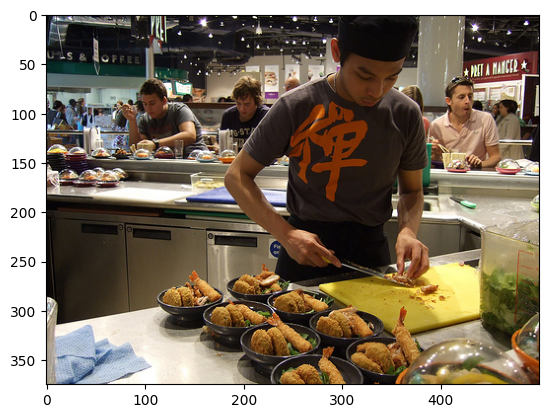

In [52]:
generate_caption('1472653060_7427d2865a.jpg')


---------------------Actual---------------------
start child in pink dress is climbing up set of stairs in an entry way end
start girl going into wooden building end
start little girl climbing into wooden playhouse end
start little girl climbing the stairs to her playhouse end
start little girl in pink dress going into wooden cabin end
--------------------Predicted--------------------
Caption: little girl in pink dress is sitting on the stairs looking at something 

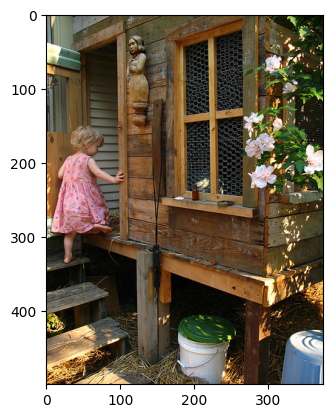

In [39]:
generate_caption('1000268201_693b08cb0e.jpg')

---------------------Actual---------------------
start boy takes jump on his skateboard while another boy with skateboard watches end
start child is performing skateboard trick while another child with skateboard leans on wall end
start little boy skateboarder is doing trick on his board while another young skateboarder watches end
start young boy skateboarder jumping on platform on skateboard end
start two skateboarders end
--------------------Predicted--------------------
Caption: man is flipping on his skateboard in front of brick wall 

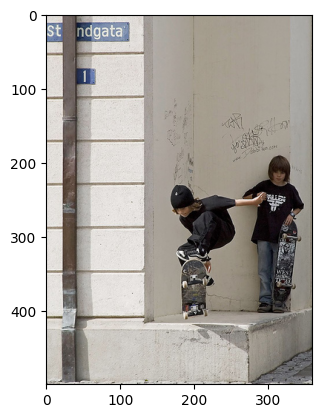

In [44]:
generate_caption('1052358063_eae6744153.jpg')

---------------------Actual---------------------
start big brown dog plays with smaller grey dog on the grass end
start the dark brown dog is playing with the light brown dog end
start two brown dogs are running through the grass end
start two brown dogs run side by side end
start two dogs running and playing rough in the grass end
--------------------Predicted--------------------
Caption: two brown dogs are running on the grass 

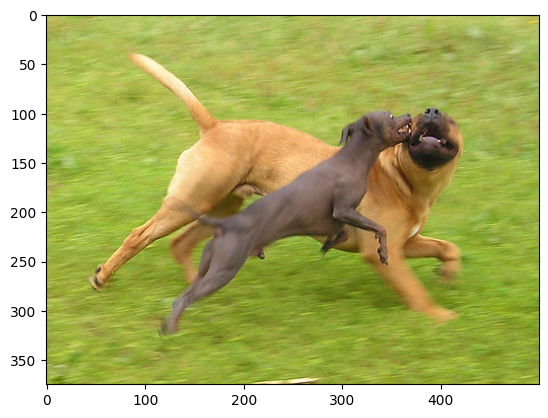

In [48]:
generate_caption('1169307342_e7a4685a5c.jpg')

---------------------Actual---------------------
start boy in striped shirt is jumping in front of water fountain end
start boy is jumping off the side of running stone water fountain in front of building end
start happy boy is jumping in front od city fountain end
start little boy is jumping in front of fountain end
start little boy is playfully jumping off the side of fountain end
--------------------Predicted--------------------
Caption: boy jumps in the air on skateboard 

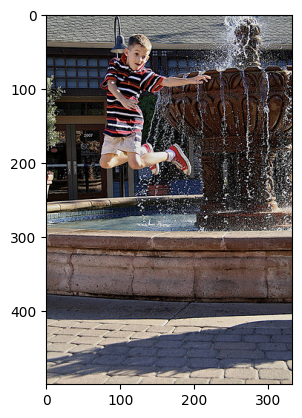

In [46]:
generate_caption("1100214449_d10861e633.jpg")